# WeatherPy
----

### Analysis
* As expected, the weather becomes significantly warmer as one approaches the equator (0 Deg. Latitude). This time of year, the equidistant north versus south latitudes have a bell shape due to southern hemisphere entering cooler weather and northern hemisphere entering warmer weather.  
* Note that more cities far from the equator exist in the Northern hemisphere.  USA, Canada, Russia and Northern Europe have more cities than far south South America and South Africa / Australia are not nearly as far-south as the northern hemisphere cities are far-north.
* Cloudiness values of 100% and 0% seem too prevalent in the citipy data and are suspected of being default values when no actual sample was available, or some similar measurement error.
* There is no strong relationship between latitude and wind speed. However, in northern hemispheres there is a flurry of cities with over 20 mph of wind.

In [2]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from scipy.stats import linregress

# Import API key
from api_keys import weather_api_key

# Incorporated citipy to determine city based on latitude and longitude
from citipy import citipy

# Output File (CSV)
output_data_file = "cities.csv"

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

## Generate Cities List

In [3]:
# List for holding lat_lngs and cities
lat_lngs = []
cities = []

# Create a set of random lat and lng combinations
lats = np.random.uniform(lat_range[0], lat_range[1], size=1500)
lngs = np.random.uniform(lng_range[0], lng_range[1], size=1500)
lat_lngs = zip(lats, lngs)

# Identify nearest city for each lat, lng combination
for lat_lng in lat_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name
    
    # If the city is unique, then add it to a our cities list
    if city not in cities:
        cities.append(city)

# Print the city count to confirm sufficient count
len(cities)

611

## Perform API Calls

In [4]:
# Starting URL for Weather Map API Call
#url = "http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=" + weather_api_key
url = "http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=" + weather_api_key

# List of city data
city_data = []

# Print to logger
print("Beginning Data Retrieval     ")
print("-----------------------------")

# Create counters
record_count = 1
set_count = 1

# Loop through all the cities in our list
for i, city in enumerate(cities):
        
    # Group cities in sets of 50 for logging purposes
    if (i % 50 == 0 and i >= 50):
        set_count += 1
        record_count = 0

    # Create endpoint URL with each city
    city_url = url + "&q=" + city
    
    # Log the url, record, and set numbers
    print("Processing Record %s of Set %s | %s" % (record_count, set_count, city))

    # Add 1 to the record count
    record_count += 1

    # Run an API request for each of the cities
    try:
        # Parse the JSON and retrieve data
        city_weather = requests.get(city_url).json()

        # Parse out the max temp, humidity, and cloudiness
        city_lat = city_weather["coord"]["lat"]
        city_lng = city_weather["coord"]["lon"]
        city_max_temp = city_weather["main"]["temp_max"]
        city_humidity = city_weather["main"]["humidity"]
        city_clouds = city_weather["clouds"]["all"]
        city_wind = city_weather["wind"]["speed"]
        city_country = city_weather["sys"]["country"]
        city_date = city_weather["dt"]

        # Append the City information into city_data list
        city_data.append({"City": city, 
                          "Lat": city_lat, 
                          "Lng": city_lng, 
                          "Max Temp": city_max_temp,
                          "Humidity": city_humidity,
                          "Cloudiness": city_clouds,
                          "Wind Speed": city_wind,
                          "Country": city_country,
                          "Date": city_date})

    # If an error is experienced, skip the city
    except:
        print("City not found. Skipping...")
        pass
              
# Indicate that Data Loading is complete 
print("-----------------------------")
print("Data Retrieval Complete      ")
print("-----------------------------")
        
        

Beginning Data Retrieval     
-----------------------------
Processing Record 1 of Set 1 | kapaa
Processing Record 2 of Set 1 | ixtapa
Processing Record 3 of Set 1 | dingle
Processing Record 4 of Set 1 | visby
Processing Record 5 of Set 1 | thompson
Processing Record 6 of Set 1 | tasiilaq
Processing Record 7 of Set 1 | rikitea
Processing Record 8 of Set 1 | mataura
Processing Record 9 of Set 1 | atuona
Processing Record 10 of Set 1 | bethel
Processing Record 11 of Set 1 | ilulissat
Processing Record 12 of Set 1 | albany
Processing Record 13 of Set 1 | kodiak
Processing Record 14 of Set 1 | shimoda
Processing Record 15 of Set 1 | dongsheng
Processing Record 16 of Set 1 | campbell river
Processing Record 17 of Set 1 | zima
Processing Record 18 of Set 1 | vardo
Processing Record 19 of Set 1 | tiksi
Processing Record 20 of Set 1 | alamogordo
Processing Record 21 of Set 1 | constitucion
Processing Record 22 of Set 1 | east london
Processing Record 23 of Set 1 | yellowknife
Processing Record

In [5]:
# Convert array of JSONs into Pandas DataFrame
city_data_pd = pd.DataFrame(city_data)

# Show Record Count
city_data_pd.count()

City          557
Lat           557
Lng           557
Max Temp      557
Humidity      557
Cloudiness    557
Wind Speed    557
Country       557
Date          557
dtype: int64

In [6]:
# Display the City Data Frame
city_data_pd.head()

,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
0,kapaa,22.0752,-159.3190,78.78,92,0,13.80,US,1651383925
1,ixtapa,20.7000,-105.2000,68.14,64,99,2.62,MX,1651383926
2,dingle,10.9995,122.6711,88.41,55,100,12.75,PH,1651383926
3,visby,57.6409,18.2960,45.05,65,100,4.61,SE,1651383927
4,thompson,55.7435,-97.8558,30.36,80,100,10.36,CA,1651383927


## Inspect the data and remove the cities where the humidity > 100%.
----
Skip this step if there are no cities that have humidity > 100%. 

In [7]:
city_data_pd.describe()

,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Date
count,557.000000,557.000000,557.000000,557.000000,557.000000,557.000000,5.570000e+02
mean,20.771978,15.779137,61.207522,68.750449,52.983842,7.557899,1.651384e+09
std,33.707490,90.379210,19.369315,22.257741,39.426483,5.182216,9.567437e+01
min,-54.800000,-179.166700,-6.790000,1.000000,0.000000,0.000000,1.651384e+09
25%,-8.419200,-64.383100,47.480000,57.000000,10.000000,3.440000,1.651384e+09
50%,26.326000,20.415800,63.000000,73.000000,57.000000,6.290000,1.651384e+09
75%,50.016300,95.960900,76.640000,86.000000,96.000000,10.760000,1.651384e+09
max,78.218600,179.316700,113.220000,100.000000,100.000000,26.640000,1.651384e+09


In [8]:
#  Get the indices of cities that have humidity over 100%.
dirty_city_data = city_data_pd[(city_data_pd["Humidity"] > 100)].index
                                  
dirty_city_data

Int64Index([], dtype='int64')

In [9]:
# Make a new DataFrame equal to the city data to drop all humidity outliers by index.
# Passing "inplace=False" will make a copy of the city_data DataFrame, which we call "clean_city_data".
clean_city_data = city_data_pd.drop(dirty_city_data, inplace=False)
clean_city_data.head()

,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
0,kapaa,22.0752,-159.3190,78.78,92,0,13.80,US,1651383925
1,ixtapa,20.7000,-105.2000,68.14,64,99,2.62,MX,1651383926
2,dingle,10.9995,122.6711,88.41,55,100,12.75,PH,1651383926
3,visby,57.6409,18.2960,45.05,65,100,4.61,SE,1651383927
4,thompson,55.7435,-97.8558,30.36,80,100,10.36,CA,1651383927


In [10]:
# Extract relevant fields from the data frame
lats = clean_city_data["Lat"]
max_temps = clean_city_data["Max Temp"]
humidity = clean_city_data["Humidity"]
cloudiness = clean_city_data["Cloudiness"]
wind_speed = clean_city_data["Wind Speed"]

# Export the City_Data into a csv
clean_city_data.to_csv(output_data_file, index_label="City_ID")

## Latitude vs. Temperature Plot

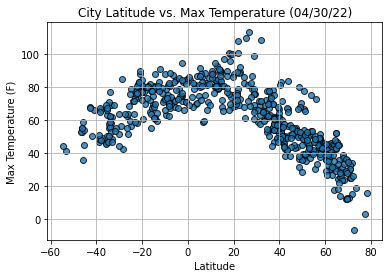

In [11]:
# Build scatter plot for latitude vs. temperature
plt.scatter(lats, 
            max_temps,
            edgecolor="black", linewidths=1, marker="o", 
            alpha=0.8, label="Cities")

# Incorporate the other graph properties
plt.title("City Latitude vs. Max Temperature (%s)" % time.strftime("%x"))
plt.ylabel("Max Temperature (F)")
plt.xlabel("Latitude")
plt.grid(True)

# Save the figure
plt.savefig("Fig1.png")

# Show plot
plt.show()

## Latitude vs. Humidity Plot

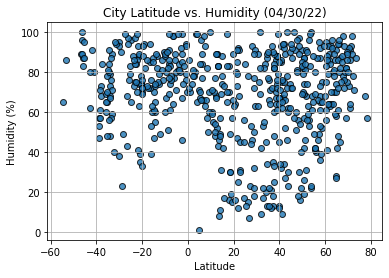

In [12]:
# Build the scatter plots for latitude vs. humidity
plt.scatter(lats, 
            humidity,
            edgecolor="black", linewidths=1, marker="o", 
            alpha=0.8, label="Cities")

# Incorporate the other graph properties
plt.title("City Latitude vs. Humidity (%s)" % time.strftime("%x"))
plt.ylabel("Humidity (%)")
plt.xlabel("Latitude")
plt.grid(True)

# Save the figure
plt.savefig("Fig2.png")

# Show plot
plt.show()

## Latitude vs. Cloudiness Plot

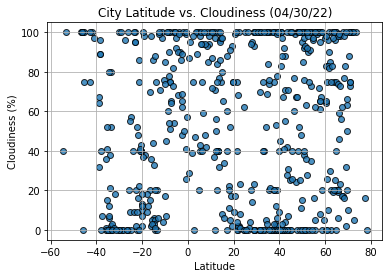

In [14]:
# Build the scatter plots for latitude vs. cloudiness
plt.scatter(lats, 
            cloudiness,
            edgecolor="black", linewidths=1, marker="o", 
            alpha=0.8, label="Cities")

# Incorporate the other graph properties
plt.title("City Latitude vs. Cloudiness (%s)" % time.strftime("%x"))
plt.ylabel("Cloudiness (%)")
plt.xlabel("Latitude")
plt.grid(True)

# Save the figure
plt.savefig("Fig3.png")

# Show plot
plt.show()

## Latitude vs. Wind Speed Plot

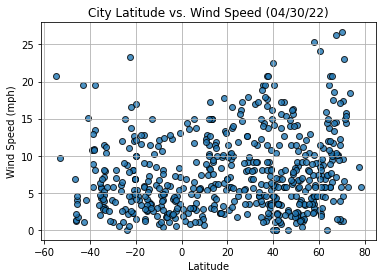

In [16]:
# Build the scatter plots for latitude vs. wind speed
plt.scatter(lats, 
            wind_speed,
            edgecolor="black", linewidths=1, marker="o", 
            alpha=0.8, label="Cities")

# Incorporate the other graph properties
plt.title("City Latitude vs. Wind Speed (%s)" % time.strftime("%x"))
plt.ylabel("Wind Speed (mph)")
plt.xlabel("Latitude")
plt.grid(True)

# Save the figure
plt.savefig("Fig4.png")

# Show plot
plt.show()

## Linear Regression

In [19]:
# Create a function to create Linear Regression plots
def plot_linear_regression(x_values, y_values, title, text_coordinates):
    
    # Run regresson on southern hemisphere
    (slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
    regress_values = x_values * slope + intercept
    line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

    # Plot
    plt.scatter(x_values,y_values)
    plt.plot(x_values,regress_values,"r-")
    plt.annotate(line_eq,text_coordinates,fontsize=15,color="red")
    plt.xlabel('Latitude')
    plt.ylabel(title)
    print(f"The r-value is: {rvalue**2}")
    plt.show()

In [20]:
# Create Northern and Southern Hemisphere DataFrames
northern_hemi_df = city_data_pd.loc[(city_data_pd["Lat"] >= 0)]
southern_hemi_df = city_data_pd.loc[(city_data_pd["Lat"] < 0)]

###  Max Temp vs. Latitude Linear Regression

The r-value is: 0.7264848881544796


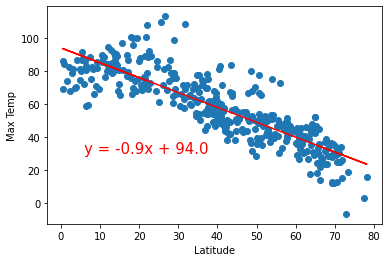

In [21]:
# Linear regression on Northern Hemisphere
x_values = northern_hemi_df["Lat"]
y_values = northern_hemi_df["Max Temp"]
plot_linear_regression(x_values, y_values, 'Max Temp',(6,30))

The r-value is: 0.4484446005649051


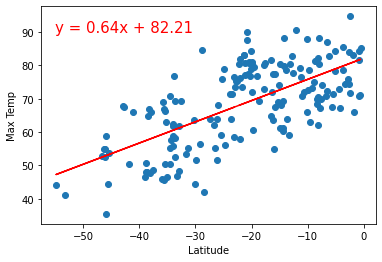

In [22]:
# Linear regression on Southern Hemisphere
x_values = southern_hemi_df["Lat"]
y_values = southern_hemi_df["Max Temp"]
plot_linear_regression(x_values, y_values, 'Max Temp', (-55, 90))

The high r value indicates a strong positive correlation between latitude and max temperature. R values ~ 0.5 indicate that there is a moderate positive correlation. 

### Humidity (%) vs. Latitude Linear Regression

The r-value is: 0.024133163896160267


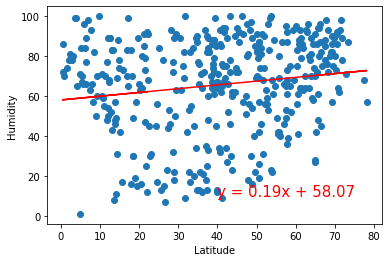

In [23]:
# Northern Hemisphere
x_values = northern_hemi_df["Lat"]
y_values = northern_hemi_df["Humidity"]
plot_linear_regression(x_values, y_values, 'Humidity',(40,10))

The r-value is: 0.00963110227372008


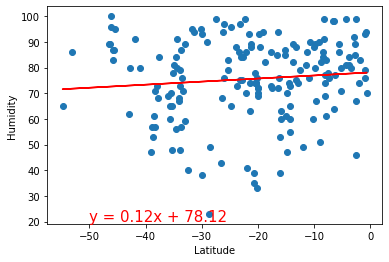

In [25]:
# Southern Hemisphere
x_values = southern_hemi_df["Lat"]
y_values = southern_hemi_df["Humidity"]
plot_linear_regression(x_values, y_values, 'Humidity', (-50, 20))

The low r values indicate a weak to no relationship between humidity and latitude.

### Cloudiness (%) vs. Latitude Linear Regression

The r-value is: 0.000622283039850717


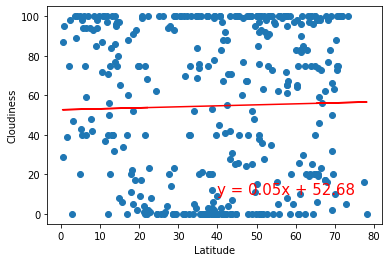

In [26]:
# Northern Hemisphere
x_values = northern_hemi_df["Lat"]
y_values = northern_hemi_df["Cloudiness"]
plot_linear_regression(x_values, y_values, 'Cloudiness', (40,10))

The r-value is: 0.032758469515886846


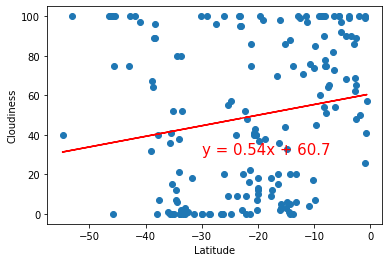

In [27]:
# Southern Hemisphere
x_values = southern_hemi_df["Lat"]
y_values = southern_hemi_df["Cloudiness"]
plot_linear_regression(x_values, y_values, 'Cloudiness', (-30,30))

The low r values indicate a weak positive relationship between latitude and cloudiness.

### Wind Speed (mph) vs. Latitude Linear Regression

The r-value is: 0.012301356949376969


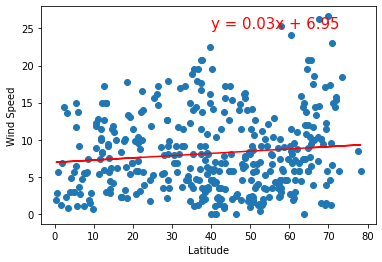

In [28]:
# Northern Hemisphere
x_values = northern_hemi_df["Lat"]
y_values = northern_hemi_df["Wind Speed"]
plot_linear_regression(x_values, y_values, 'Wind Speed', (40,25))

The r-value is: 0.02254146052548403


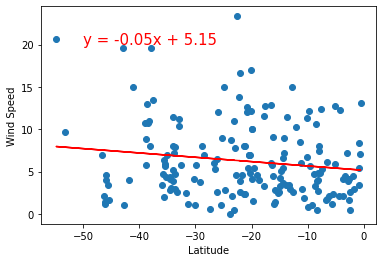

In [30]:
# Southern Hemisphere
x_values = southern_hemi_df["Lat"]
y_values = southern_hemi_df["Wind Speed"]
plot_linear_regression(x_values, y_values, 'Wind Speed', (-50, 20))

The low r values indicate that there is no real relationship between wind speed and latitude." The difference between the hemispheres doesn't seem to be significant enough to comment upon.